In [21]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
pbp = nfl.import_pbp_data([2024]) 

2024 done.
Downcasting floats.


In [23]:
rush_attempts = pbp[
    (pbp['rush_attempt'] == 1) &
    (pbp['qb_scramble'] == 0) &
    (pbp['qb_dropback'] == 0) &
    (pbp['yards_gained'].notna())
]

In [24]:
def_ypc = (
    rush_attempts[rush_attempts['defteam'].notna()]
    .groupby(['season', 'defteam'])['yards_gained']
    .mean()
    .reset_index()
    .rename(columns={'yards_gained': 'def_ypc'})
)

In [25]:
rush_attempts = rush_attempts.merge(def_ypc, on=['season', 'defteam'], how='left')


In [26]:
# 3. Getting the join dataset ready
rushing_data_join = rush_attempts[
    [
        'yards_gained',
        'yardline_100',
        'quarter_seconds_remaining',
        'half_seconds_remaining',
        'game_seconds_remaining',
        'qtr',
        'down',
        'ydstogo',
        'shotgun',
        'no_huddle',
        'ep',
        'wp',
        'def_ypc',
        'rusher_player_name',
        'posteam',
        'defteam'
    ]
].rename(columns={'yards_gained': 'label'})

rushing_data_join = rushing_data_join[
    rushing_data_join['label'].notna() &
    rushing_data_join['down'].notna()
]

In [27]:
rushes = rushing_data_join.drop(columns=['rusher_player_name', 'posteam', 'defteam'])


In [28]:
print(rushes.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11210 entries, 0 to 11240
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   label                      11210 non-null  float32
 1   yardline_100               11210 non-null  float32
 2   quarter_seconds_remaining  11210 non-null  float32
 3   half_seconds_remaining     11210 non-null  float32
 4   game_seconds_remaining     11210 non-null  float32
 5   qtr                        11210 non-null  float32
 6   down                       11210 non-null  float32
 7   ydstogo                    11210 non-null  float32
 8   shotgun                    11210 non-null  float32
 9   no_huddle                  11210 non-null  float32
 10  ep                         11210 non-null  float32
 11  wp                         11210 non-null  float32
 12  def_ypc                    11210 non-null  float32
dtypes: float32(13)
memory usage: 656.8 KB
None


In [29]:
categorical_cols = ['down', 'shotgun', 'no_huddle']
rushes[categorical_cols] = rushes[categorical_cols].astype('category')


In [30]:
rushes_encoded = pd.get_dummies(rushes, columns=categorical_cols, drop_first=False)


In [31]:
print(rushes_encoded.isna().sum())


label                        0
yardline_100                 0
quarter_seconds_remaining    0
half_seconds_remaining       0
game_seconds_remaining       0
qtr                          0
ydstogo                      0
ep                           0
wp                           0
def_ypc                      0
down_1.0                     0
down_2.0                     0
down_3.0                     0
down_4.0                     0
shotgun_0.0                  0
shotgun_1.0                  0
no_huddle_0.0                0
no_huddle_1.0                0
dtype: int64


In [32]:
# 7. Making train and test datasets
smp_size = int(0.50 * rushes_encoded.shape[0])
# Alternatively, using train_test_split
train, test = train_test_split(
    rushes_encoded,
    train_size=0.50,
    random_state=2024
)

In [33]:
# Separate features and labels
X_train = train.drop(columns=['label']).values
y_train = train['label'].values

X_test = test.drop(columns=['label']).values
y_test = test['label'].values

print(X_train.shape)
print(rushes_encoded.columns)

(5605, 17)
Index(['label', 'yardline_100', 'quarter_seconds_remaining',
       'half_seconds_remaining', 'game_seconds_remaining', 'qtr', 'ydstogo',
       'ep', 'wp', 'def_ypc', 'down_1.0', 'down_2.0', 'down_3.0', 'down_4.0',
       'shotgun_0.0', 'shotgun_1.0', 'no_huddle_0.0', 'no_huddle_1.0'],
      dtype='object')


In [34]:
# 8. Making the model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    objective='reg:squarederror',
    max_depth=6,
    learning_rate=0.25,
    early_stopping_rounds=3,
    random_state=2011
)

In [35]:
# Fit the model with early stopping
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:6.01663
[1]	validation_0-rmse:5.98210
[2]	validation_0-rmse:5.96463
[3]	validation_0-rmse:5.96103
[4]	validation_0-rmse:5.95974
[5]	validation_0-rmse:5.96338


[6]	validation_0-rmse:5.96852
[7]	validation_0-rmse:5.97858


/opt/anaconda3/envs/rush_model/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=3,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=2011, ...)

<Figure size 1000x800 with 0 Axes>

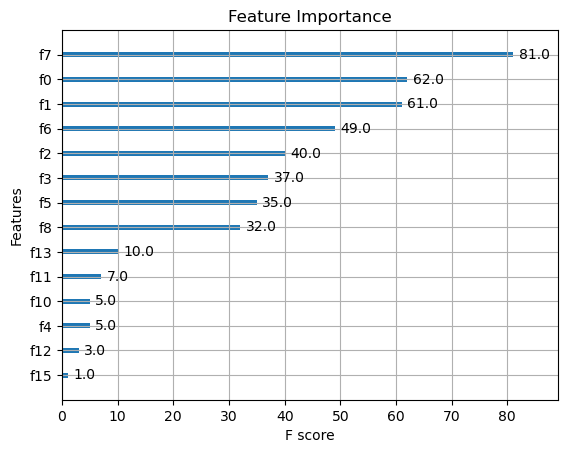

In [36]:
# 9. Feature Importance (Equivalent to vip in R)
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title('Feature Importance')
plt.show()


In [37]:
# 11. Making predictions
pred_xgb = xgb_model.predict(X_test)

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
mae = mean_absolute_error(y_test, pred_xgb)
r2 = r2_score(y_test, pred_xgb)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 5.959739714705753
MAE: 3.6432573795318604
R²: 0.03702843189239502


In [39]:
rushing_model_data = rushes_encoded.drop(columns=['label']).values
rushing_preds = xgb_model.predict(rushing_model_data)


In [40]:
ryoe_projs = rushing_data_join.copy()
ryoe_projs['exp_yards'] = rushing_preds


In [41]:
ryoe_projs['ryoe'] = ryoe_projs['label'] - ryoe_projs['exp_yards']


In [42]:
ryoe_summary = (
    ryoe_projs
    .groupby('rusher_player_name')
    .agg(
        rushes=('ryoe', 'count'),
        total_ryoe=('ryoe', 'sum')
    )
    .reset_index()
    .sort_values(by='total_ryoe', ascending=False)
)

print(ryoe_summary)


    rusher_player_name  rushes  total_ryoe
231          S.Barkley     285  410.261566
67             D.Henry     254  372.963257
128            J.Gibbs     186  241.839508
24            B.Irving     152  193.774063
140            J.Mason     153  139.882050
..                 ...     ...         ...
10          A.Mattison     104  -89.502609
209            N.Chubb     102  -95.657921
287            Z.White      65  -96.778854
85             D.Swift     212 -105.738869
172             K.Hunt     180 -136.970245

[288 rows x 3 columns]


In [45]:
# Cell [22]: Plotly Visualization of RYOE Summary

import plotly.express as px

# Select top 20 rushers by total RYOE for better visualization
top_ryoe = ryoe_summary.head(20)

fig = px.bar(
    top_ryoe,
    x='total_ryoe',
    y='rusher_player_name',
    orientation='h',
    title='Top 20 Rushers by Total RYOE',
    labels={
        'total_ryoe': 'Total RYOE',
        'rusher_player_name': 'Rusher Player Name'
    },
    hover_data=['rushes'],
    color='total_ryoe',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    xaxis_title='Total RYOE',
    yaxis_title='Rusher Player Name',
    yaxis=dict(autorange="reversed"),  # Highest RYOE at the top
    template='plotly_white',
    margin=dict(l=150, r=50, t=100, b=50)
)

fig.show()

    # Save the plot as a PNG image
fig.write_image("rushes_vs_total_ryoe_bar.png")

In [44]:
     # Cell [24]: Scatter Plot of Rushes vs Total RYOE with Labels and Export

import plotly as plt

     # Select top 50 rushers for clarity (adjust as needed)
top_rushers = ryoe_summary.head(50)

     # Create the scatter plot with labels
fig = plt.express.scatter(
         top_rushers,
         x='rushes',
         y='total_ryoe',
         title='Rushes vs Total RYOE',
         labels={
             'rushes': 'Number of Rushes',
             'total_ryoe': 'Total RYOE'
         },
         hover_data=['rusher_player_name'],
         color='total_ryoe',
         size='total_ryoe',
         color_continuous_scale='Viridis',
         trendline='ols',       # Adds a regression trendline (optional)
         text='rusher_player_name'  # Adds labels to each data point
     )

     # Update layout for better aesthetics and label positioning
fig.update_traces(
         textposition='top center',  # Positioning the labels above the points
         textfont=dict(
             size=10,
             color='black'
         )
     )

fig.update_layout(
         template='plotly_white',
         margin=dict(l=50, r=50, t=100, b=50),
         xaxis=dict(title='Number of Rushes'),
         yaxis=dict(title='Total RYOE'),
         title=dict(
             x=0.5,  # Center the title
             xanchor='center'
         )
     )

     # Display the plot
fig.show()

     # Save the plot as a PNG image
fig.write_image("rushes_vs_total_ryoe_scatter.png")